First I am going to do linear analysis on the data to see if I can predict traffic based on hour

In [3]:
import pandas as pd

df = pd.read_csv('austin_traffic.csv')
df.columns

Index(['Road Name', 'Month', 'Day', 'Year', 'Hour', 'Day of Week', 'Holiday',
       'Direction', 'Speed', 'Volume', 'Full Date'],
      dtype='object')

In [6]:
print(df['Day of Week'].max())
print(df['Day of Week'].min())


6
0


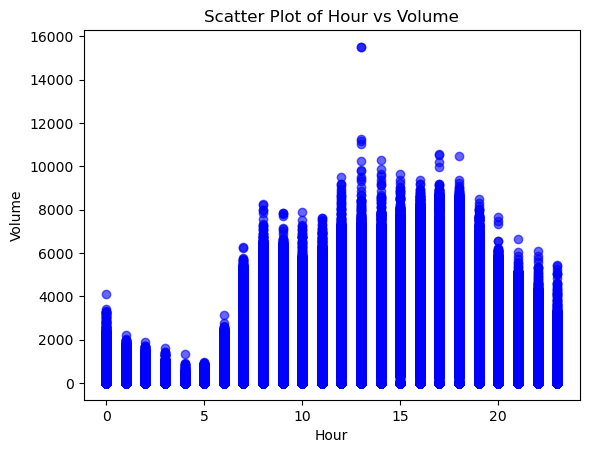

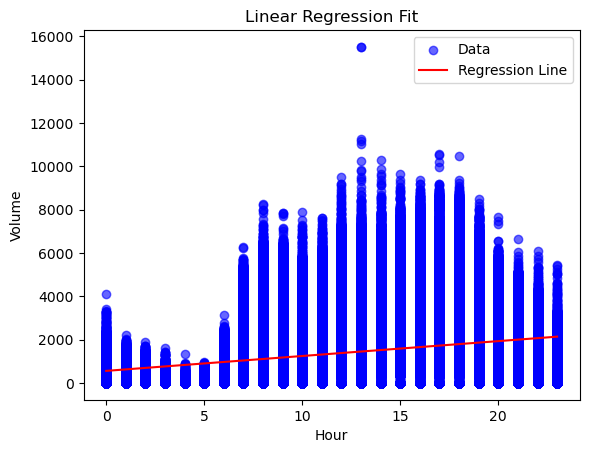

R-squared: 0.09
Mean Squared Error: 2330401.92


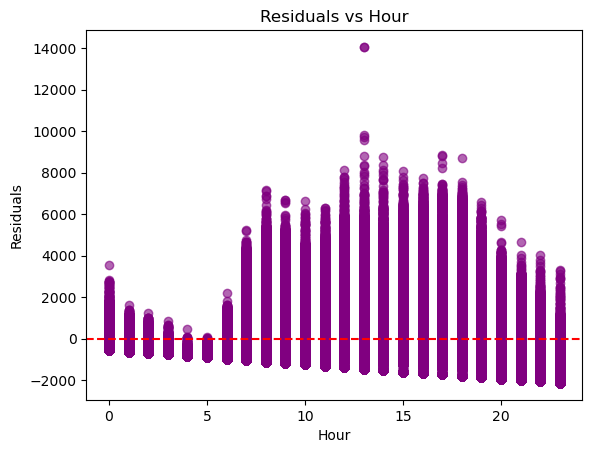

In [7]:
## Create a linear model predicting volume from hour and check for linearity 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset
# df = pd.read_csv('your_file.csv')

# Ensure no missing values
df = df.dropna(subset=['Hour', 'Volume'])

# Visualize the data
plt.scatter(df['Hour'], df['Volume'], color='blue', alpha=0.6)
plt.title('Scatter Plot of Hour vs Volume')
plt.xlabel('Hour')
plt.ylabel('Volume')
plt.show()

# Prepare data for modeling
X = df[['Hour']].values  # Feature matrix
y = df['Volume'].values  # Target variable

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Visualize the regression line
plt.scatter(df['Hour'], df['Volume'], color='blue', alpha=0.6, label='Data')
plt.plot(df['Hour'], y_pred, color='red', label='Regression Line')
plt.title('Linear Regression Fit')
plt.xlabel('Hour')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Evaluate the model
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Check residuals
residuals = y - y_pred
plt.scatter(df['Hour'], residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Hour')
plt.xlabel('Hour')
plt.ylabel('Residuals')
plt.show()


## Results of checking for linearity 

The relationship between volume and hour is not linear in its current form. The residuals are not normally distrobuted and the model does not do a good job of predicting volume.  Rather, it looks like there is an element of seasonality. 

To examine the seasonlity effect, the next model will introduce a lag volume variable to see if that increases the models predictaability. 

In [50]:
import pandas as pd

# Example dataset
# Ensure your DataFrame has the necessary columns
# df = pd.read_csv('your_file.csv')

# Convert to datetime if not already
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.sort_values(by=['Date', 'Hour'])

# Group by Date and shift the Volume
df['Lag_Volume'] = df.groupby(['Year', 'Month', 'Day'])['Volume'].shift(1)

# Optional: Handle missing values (e.g., fill with 0 or drop them)
df['Lag_Volume'] = df['Lag_Volume'].fillna(0)  # Or use df.dropna(subset=['Lag_Volume'])

# View the updated DataFrame
print(df.head())


       Road Name  Month  Day  Year  Hour  Day of Week  Holiday Direction  \
61918     BURNET      6   18  2017     0            0        1        NB   
61919     BURNET      6   18  2017     0            0        1        SB   
123838  CONGRESS      6   18  2017     0            0        1        NB   
123839  CONGRESS      6   18  2017     0            0        1        SB   
185758     LAMAR      6   18  2017     0            0        1        NB   

        Speed  Volume            Full Date       Date  Lag_Volume  
61918     NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  
61919     NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  
123838    NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  
123839    NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  
185758    NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  


R-squared: 0.52
Mean Squared Error: 1249514.59


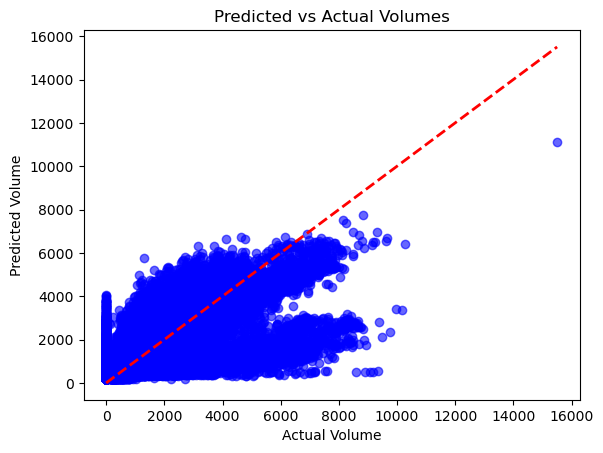

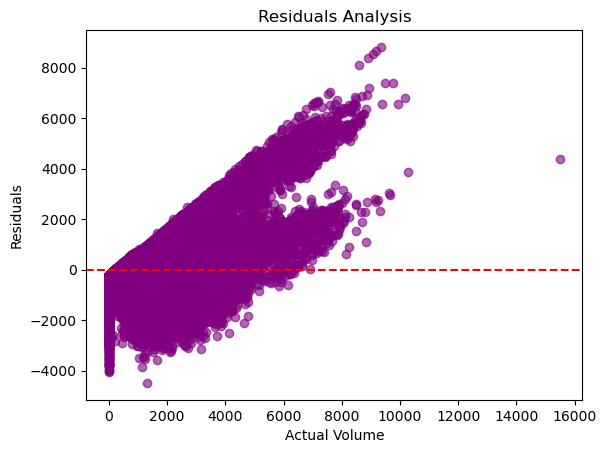

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Ensure 'Lag_Volume' is created
df['Lag_Volume'] = df.groupby(['Year', 'Month', 'Day'])['Volume'].shift(1)
df = df.dropna(subset=['Lag_Volume'])  # Drop rows with missing Lag_Volume

# Define features (X) and target (y)
X = df[['Hour', 'Lag_Volume']]  # Add other features if necessary
y = df['Volume']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Visualize predictions vs actual values
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs Actual Volumes')
plt.xlabel('Actual Volume')
plt.ylabel('Predicted Volume')
plt.show()

# Analyze Residuals
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Analysis')
plt.xlabel('Actual Volume')
plt.ylabel('Residuals')
plt.show()


## Lag Model Results

This model greatly increases the predictive performance of the model from 2% to 50%. However, the model still does not experince a linear relationship even with this new variable. 


# Neural Network for Volume Prediction

This code implements a neural network using PyTorch to predict vehicle volume based on traffic and temporal features. The process includes:

1. **Preprocessing**: Ensuring that all feature columns are numeric and splitting the data into training and testing sets.
2. **Model Architecture**: A configurable neural network with dynamic hidden layers and nodes, allowing flexibility in experimentation.
3. **Training**: Using Mean Squared Error (MSE) loss and Stochastic Gradient Descent (SGD) optimizer to minimize the prediction error.
4. **Evaluation**: Calculating Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for model accuracy.

## Results:
- Training and test losses are logged over epochs to monitor convergence.
- Final accuracy metrics (MAE and RMSE) provide insights into prediction performance.
- Loss curves are visualized for further analysis of model training dynamics.


In [4]:
# Tranformation of data to apply ciclical nature to day, month, hour, and day of week,
# Also one hot encode direction and road name

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Fill missing speed values with average speed for the corresponding hour
df['Speed'] = df.groupby('Hour')['Speed'].transform(lambda x: x.fillna(x.mean()))

# Cyclical encoding for 'Month'
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Cyclical encoding for 'Day'
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

# Cyclical encoding for 'Hour'
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for 'Day of Week'
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['Day of Week'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['Day of Week'] / 7)

# One-hot encoding for 'Road Name' and 'Direction'
encoder = ColumnTransformer(
    transformers=[
        ('road_name', OneHotEncoder(drop='first'), ['Road Name']),
        ('direction', OneHotEncoder(drop='first'), ['Direction'])
    ],
    remainder='passthrough'
)

# Apply encoding
encoded_data = encoder.fit_transform(df)

# Convert to dataframe
encoded_df = pd.DataFrame(
    encoded_data,
    columns=(encoder.named_transformers_['road_name'].get_feature_names_out(['Road Name']).tolist() +
             encoder.named_transformers_['direction'].get_feature_names_out(['Direction']).tolist() +
             df.drop(columns=['Road Name', 'Direction']).columns.tolist())
)

# Drop unnecessary columns
encoded_df.drop(columns=['Month', 'Day', 'Hour', 'Day of Week', 'Full Date'], inplace=True)

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['Speed', 'Year']
encoded_df[numerical_cols] = scaler.fit_transform(encoded_df[numerical_cols])

# The dataframe is now preprocessed and ready for neural network input.
print(encoded_df.head())



  Road Name_CONGRESS Road Name_LAMAR Road Name_LOOP 360 Direction_SB     Year  \
0                0.0             0.0                0.0          0.0  1.46448   
1                0.0             0.0                0.0          1.0  1.46448   
2                0.0             0.0                0.0          0.0  1.46448   
3                0.0             0.0                0.0          1.0  1.46448   
4                0.0             0.0                0.0          0.0  1.46448   

  Holiday     Speed Volume Month_sin Month_cos   Day_sin   Day_cos  Hour_sin  \
0       0 -0.066945  181.0      -1.0      -0.0  0.988468  0.151428 -0.258819   
1       0  0.063527  112.0      -1.0      -0.0  0.988468  0.151428 -0.258819   
2       0 -0.132181  259.0      -1.0      -0.0  0.988468  0.151428      -0.5   
3       0 -0.001709  218.0      -1.0      -0.0  0.988468  0.151428      -0.5   
4       0 -0.132181  383.0      -1.0      -0.0  0.988468  0.151428 -0.707107   

   Hour_cos DayOfWeek_sin DayOfW

Epoch [10], Training Loss: 4363952.5000, Test Loss: 4376787.5000
Epoch [20], Training Loss: 4363629.5000, Test Loss: 4376465.0000
Epoch [30], Training Loss: 4363309.5000, Test Loss: 4376144.5000
Epoch [40], Training Loss: 4362989.0000, Test Loss: 4375822.5000
Epoch [50], Training Loss: 4362664.5000, Test Loss: 4375498.0000
Epoch [60], Training Loss: 4362335.5000, Test Loss: 4375167.0000
Epoch [70], Training Loss: 4361997.0000, Test Loss: 4374827.0000
Epoch [80], Training Loss: 4361648.5000, Test Loss: 4374476.5000
Epoch [90], Training Loss: 4361286.0000, Test Loss: 4374111.5000
Epoch [100], Training Loss: 4360907.0000, Test Loss: 4373730.5000
Epoch [110], Training Loss: 4360509.5000, Test Loss: 4373330.0000
Epoch [120], Training Loss: 4360089.5000, Test Loss: 4372907.5000
Epoch [130], Training Loss: 4359644.5000, Test Loss: 4372459.0000
Epoch [140], Training Loss: 4359172.0000, Test Loss: 4371982.0000
Epoch [150], Training Loss: 4358668.0000, Test Loss: 4371474.0000
Epoch [160], Traini

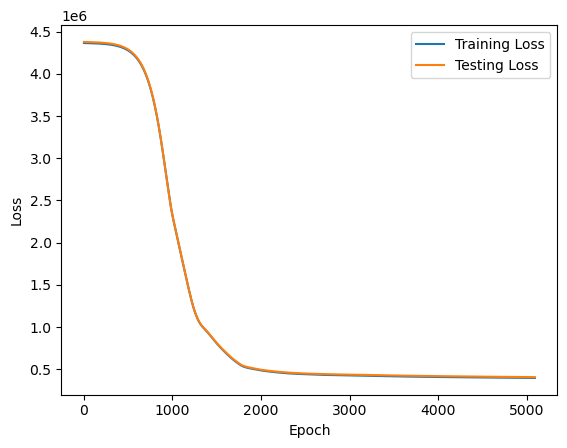

Mean Absolute Error (MAE): 403.3919
Root Mean Squared Error (RMSE): 638.9627


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Set neural network architecture parameters
set_hidden_layers = 6  # Number of hidden layers
set_hidden_nodes = 8   # Number of nodes in each hidden layer
lr = 0.01              # Learning rate

# Ensure all columns are numeric (after encoding)
encoded_df = encoded_df.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric
X = encoded_df.drop(columns=['Volume']).select_dtypes(include=[np.number]).values  # Features
y = encoded_df['Volume'].values  # Target variable (Volume)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define a neural network class with dynamic hidden layers
class VolumePredictor(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_nodes):
        super(VolumePredictor, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_nodes))  # Input layer
        layers.append(nn.ReLU())  # Activation function
        
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_nodes, hidden_nodes))  # Hidden layers
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_nodes, 1))  # Output layer
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Initialize the model
input_size = X_train.shape[1]  # Number of features
model = VolumePredictor(input_size, set_hidden_layers, set_hidden_nodes)

# Define loss function (MSE) and optimizer (SGD)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr)

# Training parameters
tolerance = 1e-5  # Convergence tolerance
prev_loss = float('inf')
epoch = 0
train_loss_values = []  # List to store training loss over epochs
test_loss_values = []   # List to store testing loss over epochs

# Training loop
while True:
    model.train()
    predictions = model(X_train_tensor)  # Forward pass
    loss = criterion(predictions, y_train_tensor)  # Compute training loss
    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Backpropagation
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()  # Update weights

    train_loss_values.append(loss.item())  # Record training loss
    loss_change = prev_loss - loss.item()
    epoch += 1
    prev_loss = loss.item()

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
        test_loss_values.append(test_loss.item())

    if loss_change < tolerance:  # Check for convergence
        print(f"Convergence reached at epoch {epoch} with loss change of {loss_change:.6f}")
        break

    if epoch % 10 == 0:  # Print progress every 10 epochs
        print(f'Epoch [{epoch}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Ensure test loss matches train loss in length for plotting
while len(test_loss_values) < len(train_loss_values):
    test_loss_values.append(test_loss_values[-1])

# Plot training and testing loss
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model accuracy with MAE and RMSE
y_test_pred = test_predictions.numpy()
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


In [6]:
# Evaluate model accuracy on the training and test sets
model.eval()

with torch.no_grad():
    # Predictions for training and test sets
    y_train_pred = model(X_train_tensor).numpy()
    y_test_pred = model(X_test_tensor).numpy()

# Calculate metrics for training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = 1 - (np.sum((y_train - y_train_pred.flatten())**2) / np.sum((y_train - np.mean(y_train))**2))

# Calculate metrics for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = 1 - (np.sum((y_test - y_test_pred.flatten())**2) / np.sum((y_test - np.mean(y_test))**2))

# Print accuracy metrics
print("Training Set Metrics:")
print(f"  Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"  R² Score: {train_r2:.4f}")

print("Test Set Metrics:")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"  R² Score: {test_r2:.4f}")

# Calculate MAPE for training set
train_mape = np.mean(np.abs((y_train - y_train_pred.flatten()) / y_train)) * 100
train_accuracy = 100 - train_mape  # Convert MAPE to percent accuracy

# Calculate MAPE for test set
test_mape = np.mean(np.abs((y_test - y_test_pred.flatten()) / y_test)) * 100
test_accuracy = 100 - test_mape  # Convert MAPE to percent accuracy

# Print percent accuracy for training and test sets
print("Training Set Percent Accuracy: {:.2f}%".format(train_accuracy))
print("Test Set Percent Accuracy: {:.2f}%".format(test_accuracy))



Training Set Metrics:
  Mean Absolute Error (MAE): 399.7475
  Root Mean Squared Error (RMSE): 631.4866
  R² Score: 0.8439
Test Set Metrics:
  Mean Absolute Error (MAE): 403.3919
  Root Mean Squared Error (RMSE): 638.9627
  R² Score: 0.8406
Training Set Percent Accuracy: -inf%
Test Set Percent Accuracy: -inf%


/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_19110/4026807549.py:31: RuntimeWarning: divide by zero encountered in true_divide
  train_mape = np.mean(np.abs((y_train - y_train_pred.flatten()) / y_train)) * 100
/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_19110/4026807549.py:35: RuntimeWarning: divide by zero encountered in true_divide
  test_mape = np.mean(np.abs((y_test - y_test_pred.flatten()) / y_test)) * 100


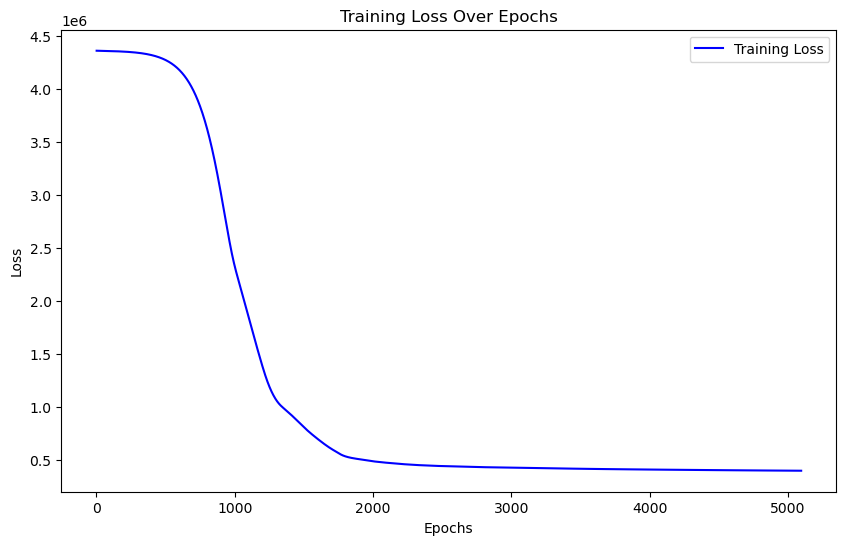

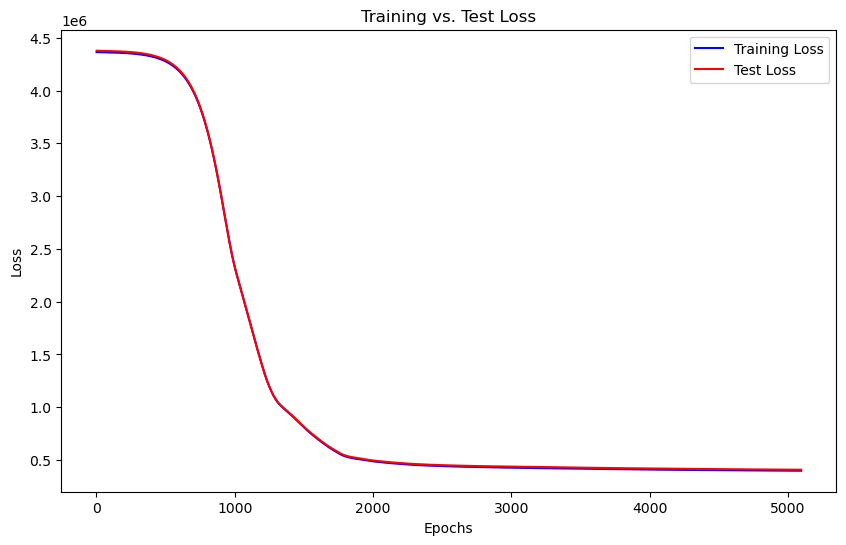

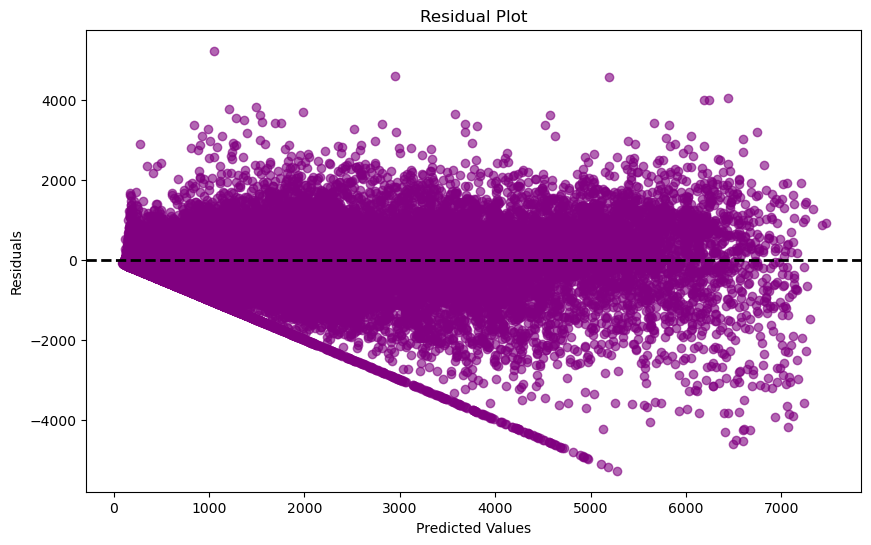

In [7]:
# 1. Plotting the Training Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# 2. Training vs. Test Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label='Training Loss', color='blue')
plt.plot(range(1, len(test_loss_values) + 1), test_loss_values, label='Test Loss', color='red')  # Track test losses
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Test Loss')
plt.legend()
plt.show()

# 3. Residual Plot
# Generate predictions on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Ensure predictions and y_test_tensor have the same shape
predictions = predictions.squeeze()
y_test_tensor = y_test_tensor.squeeze()

# Calculate residuals
residuals = y_test_tensor - predictions

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


## Better attempt at NN

I am using the homeworks to base this next NN off of rather than just guess as above. Seeing if I can bet a better predictive accuracy than above. 

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch
import tqdm
import copy

# Drop 'Full Date' column
df = df.drop(columns=['Full Date'])

# Separate features and target
X = df.drop(columns=['Volume'])
y = df['Volume']

# Hot encode categorical columns
categorical_cols = ['Road Name', 'Direction', 'Year']
numerical_cols = list(set(X.columns) - set(categorical_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Transform features
X_transformed = preprocessor.fit_transform(X)

# Train-test split
X_train_split, X_test_scaled, Y_train_split, Y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)
X_train_split, X_validation, Y_train_split, Y_validation = train_test_split(
    X_train_split, Y_train_split, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2 of original
)


In [9]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train_split, dtype=torch.float32)
X_valid = torch.tensor(X_validation, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train = torch.tensor(Y_train_split.values.reshape(-1, 1), dtype=torch.float32)
y_valid = torch.tensor(Y_validation.values.reshape(-1, 1), dtype=torch.float32)
y_test = torch.tensor(Y_test.values.reshape(-1, 1), dtype=torch.float32)


In [17]:
import torch.nn as nn

class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, nonlin, num_classes=1):
        super(MyModule, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(inp_size, hidden_sizes[0]),
            nonlin,
            *[
                layer
                for i in range(len(hidden_sizes) - 1)
                for layer in (
                    nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]),
                    nonlin,
                )
            ],
            nn.Linear(hidden_sizes[-1], num_classes)  # Adjust output layer
        )
    def forward(self, x):
        return self.layers(x)


In [20]:
def train(model, X_train, y_train, X_valid, y_valid, n_epochs, batch_size, optimizer, loss_fn):
    import torch
    from torch.utils.data import DataLoader, TensorDataset

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).view(-1, 1)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize variables to track best model
    best_weights = None
    best_mse = float('inf')
    train_history = []
    valid_history = []

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluate on validation data
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_valid_tensor)
            val_loss = loss_fn(val_predictions, y_valid_tensor).item()

        # Track the best model weights
        if val_loss < best_mse:
            best_mse = val_loss
            best_weights = model.state_dict()

        train_history.append(epoch_loss / len(train_loader))
        valid_history.append(val_loss)

        # Print progress
        print(f"Epoch [{epoch + 1}/{n_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return best_weights, train_history, valid_history, best_mse


In [23]:
from sklearn.metrics import r2_score

# Evaluate Function
# Evaluate Function
def eval(model, X, y):
    model.eval()
    # Convert inputs to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    with torch.no_grad():
        y_pred = model(X_tensor)
        mse = F.mse_loss(y_pred, y_tensor).item()
        r2 = r2_score(y, y_pred.numpy())  # Convert predictions to numpy for sklearn
    return mse, r2

# Train Function remains the same as in your example


In [31]:
from sklearn.model_selection import ParameterGrid
import copy

# Define parameter grid
param_grid = {
    'inp_size': [X_train.shape[1]],
    'hidden_sizes': [[16, 8], [32, 16, 8]],
    'lr': [0.001, 0.01],
    'n_epochs': [10, 20],
    'batch_size': [64, 128]
}

best_model = None
best_weights = None
best_mse = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    # Initialize model
    model = MyModule(
        inp_size=params['inp_size'],
        hidden_sizes=params['hidden_sizes'],
        nonlin=nn.ReLU()
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = nn.MSELoss()

    # Train the model and get results
    current_weights, train_history, valid_history, current_mse = train(
        model, 
        X_train, 
        y_train, 
        X_valid, 
        y_valid, 
        params['n_epochs'], 
        params['batch_size'], 
        optimizer, 
        loss_fn
    )

    # Check if this model is the best so far
    if current_mse < best_mse:
        best_mse = current_mse
        best_model = copy.deepcopy(model)  # Save the entire model
        best_weights = copy.deepcopy(current_weights)  # Save the best weights
        best_params = params  # Save the best hyperparameters

print(f"Best MSE: {best_mse}")
print(f"Best Params: {best_params}")


/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_19110/1697249337.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_19110/1697249337.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_19110/1697249337.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid_tensor = torch.tenso

Epoch [1/10], Training Loss: 4953139759.9375, Validation Loss: 1034399.1875
Epoch [2/10], Training Loss: 2046517572.5156, Validation Loss: 826835.0000
Epoch [3/10], Training Loss: 1823193418.8750, Validation Loss: 770852.6875
Epoch [4/10], Training Loss: 1715583828.7344, Validation Loss: 732435.6875
Epoch [5/10], Training Loss: 1629030524.8125, Validation Loss: 695723.0000
Epoch [6/10], Training Loss: 1538876524.8125, Validation Loss: 658180.6875
Epoch [7/10], Training Loss: 1455484519.1719, Validation Loss: 624269.1250
Epoch [8/10], Training Loss: 1390513898.5156, Validation Loss: 599573.8125
Epoch [9/10], Training Loss: 1338249199.0938, Validation Loss: 578734.0000
Epoch [10/10], Training Loss: 1296569760.8594, Validation Loss: 562040.0000
Epoch [1/20], Training Loss: 5381131362.8438, Validation Loss: 1125106.7500
Epoch [2/20], Training Loss: 2162692215.4688, Validation Loss: 848317.6875
Epoch [3/20], Training Loss: 1873056150.9844, Validation Loss: 793095.1250
Epoch [4/20], Training

In [33]:
import torch.nn.functional as F
# Evaluate on test set
test_mse, test_r2 = eval(best_model, X_test, y_test)
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")



Test MSE: 216110.09375
Test R2: 0.9156193137168884


/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_19110/2329514033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_19110/2329514033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
